In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, classification_report


In [49]:
#load data

df = pd.read_csv("loan_data.csv")
#X = df.drop(columns=["customer_id", "default"]) #dropping identifier and target variable before model training
#y = df["default"]
df['payment_to_income'] = df['loan_amt_outstanding'] / df['income']
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']

# features to use
features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income',
            'years_employed', 'fico_score']

X = df[features]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(
    solver="lbfgs",
    C=0.5,
    max_iter=1000,
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(C=0.5, max_iter=1000, random_state=42)

# Random Forest

In [51]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=300,
                       random_state=42)

# XGBoost

In [52]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Calibrate all models (Isotonic)

In [53]:
calibrated_lr = CalibratedClassifierCV(log_reg, method="isotonic", cv=3)
calibrated_lr.fit(X_train_scaled, y_train)

calibrated_rf = CalibratedClassifierCV(rf, method="isotonic", cv=3)
calibrated_rf.fit(X_train, y_train)

calibrated_xgb = CalibratedClassifierCV(xgb, method="isotonic", cv=3)
calibrated_xgb.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.8,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None, ...),
                       method='isotonic')

Predict probabilities

In [54]:
models = {
    "Logistic Regression": (calibrated_lr, X_test_scaled),
    "Random Forest": (calibrated_rf, X_test),
    "XGBoost": (calibrated_xgb, X_test)
}

results = []

for name, (model, X_data) in models.items():
    y_pred = model.predict_proba(X_data)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_pred)
    results.append((name, auc, brier))
    print(f"\n{name}")
    print(f"AUC: {auc:.3f}, Brier: {brier:.4f}")
    print(classification_report(y_test, (y_pred > 0.5).astype(int)))


Logistic Regression
AUC: 0.999, Brier: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.99      0.99       348

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000


Random Forest
AUC: 0.998, Brier: 0.0059
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1652
           1       0.98      0.97      0.98       348

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000


XGBoost
AUC: 0.998, Brier: 0.0031
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.99      0.99       348

    accuracy                           1.00      2000
   ma

 Plot ROC curves

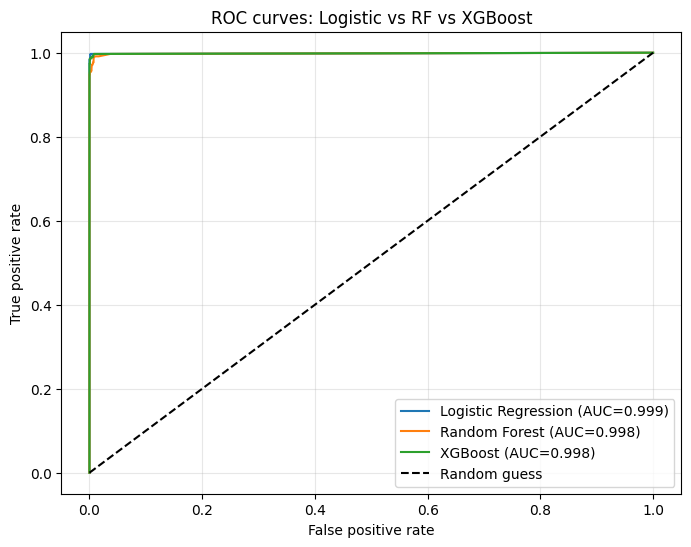

In [56]:
plt.figure(figsize=(8,6))
for name, (model, X_data) in models.items():
    y_pred = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "k--", label="Random guess")
plt.title("ROC curves: Logistic vs RF vs XGBoost")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Reliability (calibration) plot

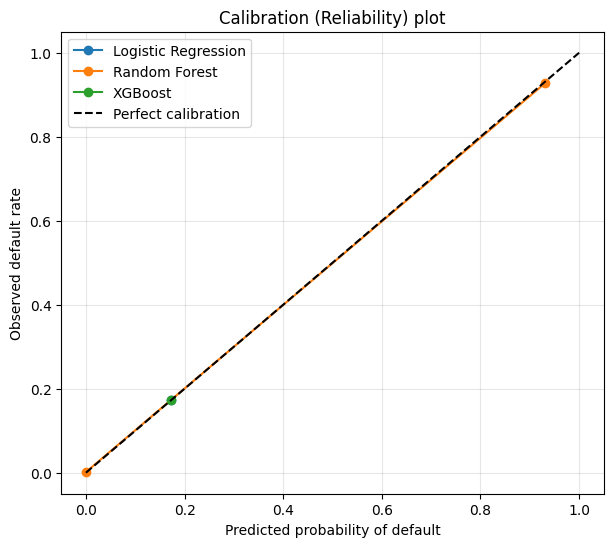

In [55]:


def calibration_plot(y_true, y_pred, n_bins=10, label=None):
    """Plot avg predicted PD vs actual default rate by decile."""
    df_temp = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    df_temp["bucket"] = pd.qcut(df_temp["y_pred"], q=n_bins, duplicates="drop")
    grouped = df_temp.groupby("bucket", observed=False).agg(
        avg_predicted=("y_pred", "mean"),
        actual_default=("y_true", "mean")
    )
    plt.plot(grouped["avg_predicted"], grouped["actual_default"], "o-", label=label)

plt.figure(figsize=(7,6))
for name, (model, X_data) in models.items():
    y_pred = model.predict_proba(X_data)[:, 1]
    calibration_plot(y_test, y_pred, label=name)

plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.title("Calibration (Reliability) plot")
plt.xlabel("Predicted probability of default")
plt.ylabel("Observed default rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



 Summary Table



In [57]:
results_df = pd.DataFrame(results, columns=["Model", "AUC", "Brier Score"])
print("\n Model performance summary:")
print(results_df.sort_values("AUC", ascending=False))


 Model performance summary:
                 Model       AUC  Brier Score
0  Logistic Regression  0.998540     0.002036
2              XGBoost  0.998471     0.003139
1        Random Forest  0.998148     0.005872


#Expected Loss Function

In [58]:
def expected_loss(model, loan_features, recovery_rate=0.10, scaler=None, scale_features=False, model_features=None):
    if isinstance(loan_features, dict):
        loan_features = pd.DataFrame([loan_features])

    # Keep only features the model was trained on
    if model_features is not None:
        X_model = loan_features[model_features]
    else:
        X_model = loan_features

    # Scaling (if needed) (Logistic Regression)
    if scale_features and scaler is not None:
        X_model = scaler.transform(X_model)

    pd_value = model.predict_proba(X_model)[:, 1][0]

    # Use loan_amt_outstanding from the dictionary for EL
    ead = loan_features["loan_amt_outstanding"].iloc[0]
    lgd = 1 - recovery_rate
    expected_loss_value = pd_value * lgd * ead

    return expected_loss_value, pd_value


Example: Predict for New Borrower



In [60]:
new_loan = {
    "credit_lines_outstanding": 3,
    "debt_to_income": 15000/55000,
    "payment_to_income": 7000/55000,
    "years_employed": 2,
    "fico_score": 580,
    "loan_amt_outstanding": 7000  # only used for EL calculation
}

model_features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']


# --- XGBoost ---
el_xgb, pd_xgb = expected_loss(calibrated_xgb, new_loan , model_features=model_features)
print(f"\n XGBoost → PD: {pd_xgb:.2%},  EL: ${el_xgb:,.2f}")

# --- Logistic Regression (requires scaling) ---
el_lr, pd_lr = expected_loss(calibrated_lr, new_loan, scaler=scaler, scale_features=True, model_features=model_features)
print(f"\n Logistic regression → PD: {pd_lr:.2%},  EL: ${el_lr:,.2f}")

# --- Random Forest (no scaling) ---
el_rf, pd_rf = expected_loss(calibrated_rf, new_loan, model_features=model_features)
print(f"\n Random forest → PD: {pd_rf:.2%},  EL: ${el_rf:,.2f}")



 XGBoost → PD: 100.00%,  EL: $6,300.00

 Logistic regression → PD: 100.00%,  EL: $6,300.00

 Random forest → PD: 100.00%,  EL: $6,300.00
